In [44]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [45]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [46]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [47]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///resources/hawaii.sqlite")
conn = engine.connect()

In [48]:
# reflect an existing database into a new model
Base= automap_base()

# reflect the tables
Base.prepare(engine, reflect= True)


In [49]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [50]:
# Save references to each table
Measurement = Base.classes.measurement
Station= Base.classes.station

In [51]:
# Create our session (link) from Python to the DB
session= Session(engine)

# Exploratory Precipitation Analysis

In [52]:
# Inspect database
inspector= inspect(engine)
columns= inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [53]:
# Find the most recent date in the data set.
recent_date= session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date           

('2017-08-23')

In [54]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.datetime(2017,8,23)- dt.timedelta(days=365)
print("year_ago:", year_ago)

# Perform a query to retrieve the data and precipitation scores
rainfall_score= session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>= year_ago).all()
rainfall_score

# Save the query results as a Pandas DataFrame and set the index to the date column
rainfall_df = pd.DataFrame(rainfall_score, columns = ['Date','Precipitation'])
rainfall_df.set_index('Date',inplace=True)
rainfall_df



year_ago: 2016-08-23 00:00:00


,Precipitation
Date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


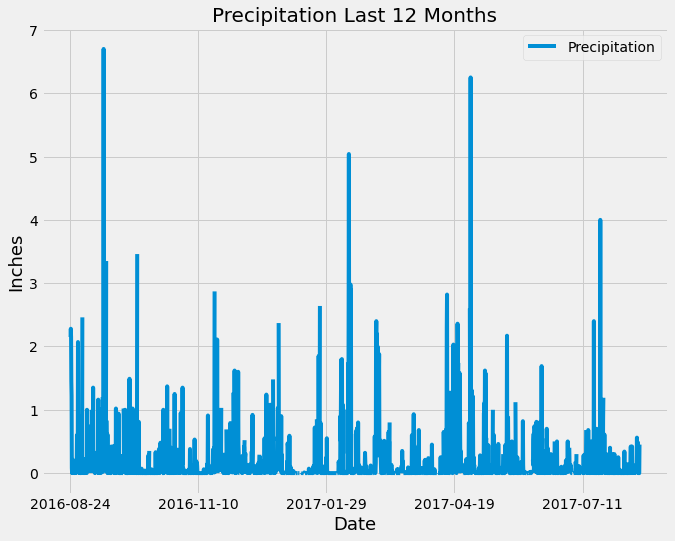

In [55]:

# Sort the dataframe by date
sorted_df= rainfall_df.sort_values(by=['Date'])
sorted_df
# Use Pandas Plotting with Matplotlib to plot the data

sorted_df.plot(figsize=(10,8))
plt.locator_params(axis ='x', nbins =9)
plt.title('Precipitation Last 12 Months', size =20)
plt.xlabel('Date', size =18)
plt.ylabel('Inches', size =18)
plt.savefig("images/Precipitation.png")
plt.show()

In [56]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [57]:
columns =inspector.get_columns("station")
for c in columns:
    print(c['name'],c['type'])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [58]:
# Design a query to calculate the total number stations in the dataset
tot_station = session.query(Station.station).count()
tot_station

9

In [59]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_station= session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).first()
most_active_station


('USC00519281', 2772)

In [60]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp=[Measurement.station,
     func.min(Measurement.tobs),
     func.avg(Measurement.tobs),
     func.max(Measurement.tobs)]
most_active_stat = session.query(*temp).\
    filter(Measurement.station =='USC00519281').\
    group_by(Measurement.station).\
    order_by(Measurement.station).all()
most_active_stat

[('USC00519281', 54.0, 71.66378066378067, 85.0)]

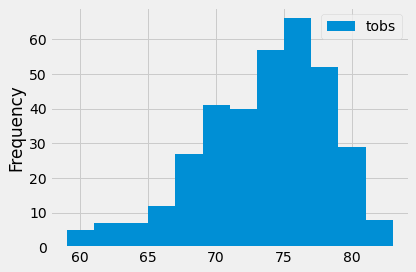

In [66]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

query_date = dt.datetime(2017,8,23) - dt.timedelta(days=365)
temp_results = session.query(Measurement.tobs).\
                            filter(Measurement.station =='USC00519281').\
                            filter(Measurement.date>= query_date).all()
#temp_results

df = pd.DataFrame(temp_results, columns=['tobs'])
df.plot.hist(bins=12)
plt.tight_layout()
plt.savefig("images/Histogram_temp.png")


# Close session

In [62]:
# Close Session
session.close()